# **Homework 1**
Dataset: Heart.cvs


# Dataset & setup


For the last part (record linkage) we'll use the code in the project available at https://recordlinkage.readthedocs.io/en/latest/about.html, which must be installed.

In [1]:
!pip install recordlinkage

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 926 kB 4.0 MB/s 
     |████████████████████████████████| 132 kB 60.5 MB/s 
  Created wheel for jellyfish: filename=jellyfish-0.9.0-cp37-cp37m-linux_x86_64.whl size=73988 sha256=2c8bb3fc0c31e8ff1d1f2079b889f7072ea44f975acfda5b5439904b836a7d0b
  Stored in directory: /root/.cache/pip/wheels/fe/99/4e/646ce766df0d070b0ef04db27aa11543e2767fda3075aec31b
Successfully built jellyfish


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
from scipy.linalg import cholesky
from sklearn.decomposition import PCA
from pathlib import Path
import recordlinkage

The dataset contains the following attributes:

*   **age**: Age of the patient
*   **sex**: Sex of the patient (0 = female, 1 = male)
*   **cp**: Chest Pain:
   *   Value 1: typical angina
   *   Value 2: atypical angina
   *   Value 3: non-angina pain
   *   Value 4: asymptomatic
*   **trtbps**: Resting blood pressure (in mm Hg)
*   **chol**: Cholesterol in mg/dl fetched via BMI sensor
*   **fbs**: Fasting blood sugar > 120 mg/dl (0 = false, 1 = true)
*   **restecg**: resting electrocardiographic results
   *   Value 0: Normal
   *   Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
   *   Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
*   **thalachh**: Maximum heart rate achieved
*   **exng**: Exercise induced angina (1 = yes, 0 = no)
*   **oldpeak**: ST depression induced by exercise relative to rest
*   **slp**: The slope of the peak exercise ST segment (ST segment is an indicator of heart desease)
*   **caa**: Number of major vessels (0-3)
*   **thall**: Thalassemia rate

*   **target**: Diagnosis of heart disease (0 = low chances of heart attack, 1 = high chances of heart attack)






In [3]:
url = 'https://raw.githubusercontent.com/Kekkodf/Privacy-Preserving-Information-Access/main/heart.csv'

heartdf = pd.read_csv(url)

heartdf

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


##Useful info about data
More info about the identifiers, usefull to aggregate some data in the next steps and to understad the kind of attributes:

*   **Angina**: Chest pain due to reduced blood flow to the heart muscles. There're 3 types of angina: stable angina, unstable angina, and variant angina. 
*   **Cholesterol**: A waxy substance found in the body cells and it belongs to a group of organic molecules called lipids. There are 3 types of cholesterol; high-density lipoprotein (HDL) and it's known as the "good cholesterol", low-density lipoprotein (LDL) known as the "bad cholesterol", and very-low-density lipoproteins (VLDL) and as the name implies, they're low dense particles that carry triglycerides in the blood.
*   **ECG**: Short for electrocardiogram, it's a routine test usually done to check the heart's electrical activity.
*   **ST depression**: A type of ST-segment abnormality. the ST segment is the flat, isoelectric part of the ECG and it represents the interval between ventricular depolarization and repolarization.
*   **Thalassemia**: It's a genetic blood disorder that is characterized by a lower rate of hemoglobin than normal.

We now see the distribution of our data for each category

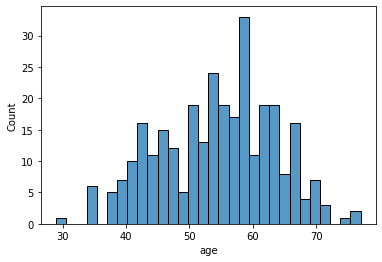

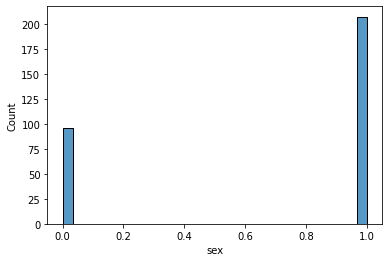

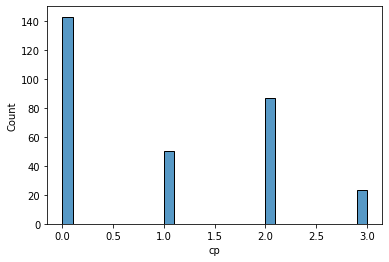

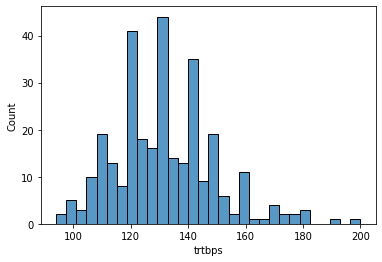

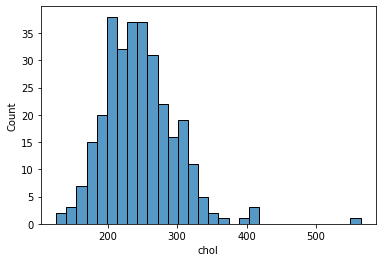

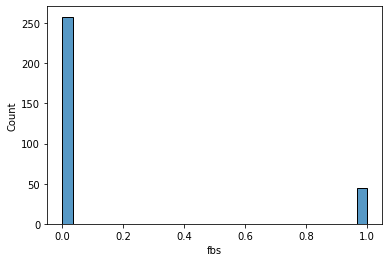

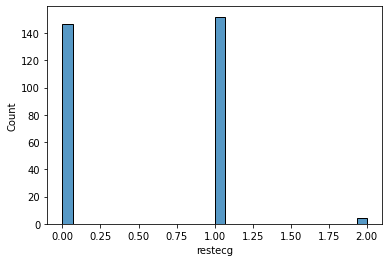

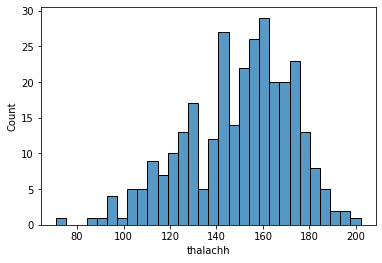

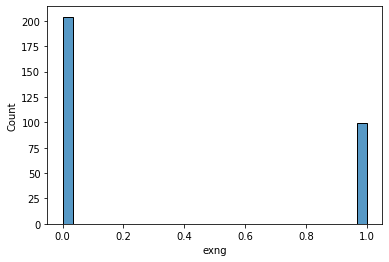

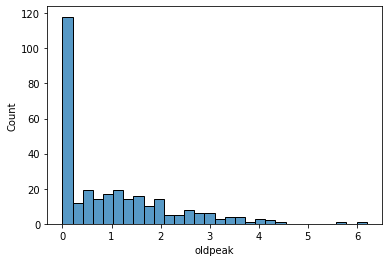

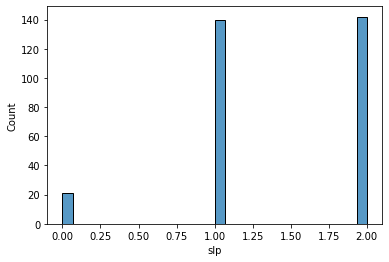

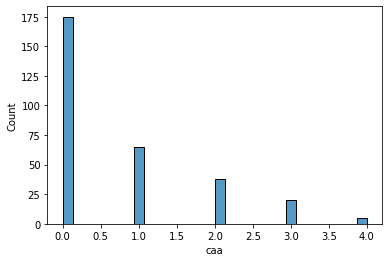

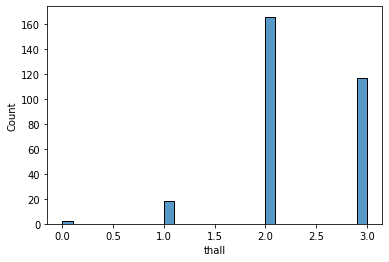

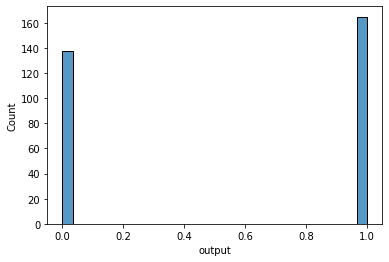

In [4]:
cat_list = heartdf.iloc[:14:]

for cat in cat_list:
  sns.histplot(data=heartdf, x=cat, bins=30)
  print('\t')
  plt.show()

#Sensitive cells: First techniques

##Double entry table

In [5]:
#convert sex/cp columns in a double entry table
macrodata_chestpain = heartdf[['sex', 'cp']]
macrodata_chestpain = macrodata_chestpain.reset_index().rename({0:'count'}, axis=1)
macrodata_chestpain = macrodata_chestpain.pivot_table(index='sex', columns='cp', aggfunc='count')

In [6]:
print('Female = 0')
print('Male = 1')
macrodata_chestpain

Female = 0
Male = 1


index            
cp      0   1   2   3
sex                  
0      39  18  35   4
1     104  32  52  19

##Rounding

Round the 'oldpeak' values to the upper closest integer, if we want the lower closet integer the method is commented.

In [7]:
df = heartdf
df['oldpeak'] = df['oldpeak'].apply(np.ceil) #.apply(np.floor)
df

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,3.0,0,0,1,1
1,37,1,2,130,250,0,1,187,0,4.0,0,0,2,1
2,41,0,1,130,204,0,0,172,0,2.0,2,0,2,1
3,56,1,1,120,236,0,1,178,0,1.0,2,0,2,1
4,57,0,0,120,354,0,1,163,1,1.0,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,1.0,1,0,3,0
299,45,1,3,110,264,0,1,132,0,2.0,1,0,3,0
300,68,1,0,144,193,1,1,141,0,4.0,1,2,3,0
301,57,1,0,130,131,0,1,115,1,2.0,1,1,3,0


In [8]:
#reset dataset
heartdf = pd.read_csv(url)

Round 'age' and 'chol' values to the closest multiple of a chosen base number

In [9]:
def base_round(x, b):
  return (b * round(x/b)).astype('int')

df = heartdf
df['round_age'] = base_round(df['age'],4)
df['round_chol'] = base_round(df['chol'], 6)
df_concat = pd.concat([heartdf[['age']], df[['round_age']], heartdf[['chol']], df[['round_chol']]], axis=1)
df_concat

,age,round_age,chol,round_chol
0,63,64,233,234
1,37,36,250,252
2,41,40,204,204
3,56,56,236,234
4,57,56,354,354
...,...,...,...,...
298,57,56,241,240
299,45,44,264,264
300,68,68,193,192
301,57,56,131,132


In [10]:
#reset dataset
heartdf = pd.read_csv(url)

##Cell Suppression

Some classification of cholesterol are 'Desiderable' ($<$200 mg/dL), 'Moderete high' (200-239 mg/dL) and 'Very high' ($>$240 mg/dL).
So if we want to protect the minorities in the database we should choose values according to the distributions of the histograms displayed above.
We can do the same for other columns as 'age' and 'trtbps'.


In [11]:
#cholesterol (to protect minorities)
df = heartdf['chol']
x = pd.to_numeric(df, downcast='integer')
for i in range (len(df)):
  if (x[i]>=350):
    x[i] = 'NaN'
heartdf['chol'] = x
#age
df = heartdf['age']
x = pd.to_numeric(df, downcast='integer')
for i in range (len(df)):
  if (x[i]<40):
    x[i] = 'NaN'
heartdf['age'] = x
#blood pressure
df = heartdf['trtbps']
x = pd.to_numeric(df, downcast='integer')
for i in range (len(df)):
  if (x[i]>180):
    x[i] = 'NaN'
heartdf['trtbps'] = x
heartdf

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,NaN,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,NaN,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [12]:
#reset dataset
heartdf = pd.read_csv(url)

#SENSITIVE CELLS: MAGNITUDES OPERATIONS


##(n,k)-rule

To determine which cells are sensitive using the n-k rule, we need to determine how much each individual is responsible for the value of the cell.


In [13]:
def nkrule(values, n, k):
    contribution = values/np.sum(values)
    print(f"contributions: {contribution}")
    print(f"number of individuals contributing more than {k}: {np.sum(contribution>k)}")
    return np.sum(contribution>k)<n

In [14]:
n = 3
k = 0.4

contr = np.array(heartdf[(heartdf['sex']==0) &
                         (heartdf['caa']==2)]['cp'])

print(f"is the cell sensible according to ({n}-{k}) rule?: {nkrule(contr, n, k)}\n")
k = 0.1
print(f"is the cell sensible according to ({n}-{k}) rule?: {nkrule(contr, n, k)}\n")

contributions: [0.5        0.16666667 0.16666667 0.         0.         0.
 0.         0.         0.         0.         0.         0.16666667
 0.        ]
number of individuals contributing more than 0.4: 1
is the cell sensible according to (3-0.4) rule?: True

contributions: [0.5        0.16666667 0.16666667 0.         0.         0.
 0.         0.         0.         0.         0.         0.16666667
 0.        ]
number of individuals contributing more than 0.1: 4
is the cell sensible according to (3-0.1) rule?: False



##p-percentage

In [15]:
#include also (p,q)-rule if p := p/q
def ppercentage(values, p):
  contribution = values/np.sum(values)
  t = np.array(contribution)
  v = np.array(contribution)
  v = np.flip(np.sort(v))
  for i in range (len(t)):
    resp = t[i]-(v[0]-v[1]) < (p/100)*v[0]
    if resp == True:
      print(f"Cell {i} is the cell sensible according to {p}-percentage rule.\n")

In [16]:
p = 0.2

contr = np.array(heartdf[(heartdf['sex']==0) &
                         (heartdf['caa']==2)]['cp'])

print(contr/np.sum(contr))
print('\t')
ppercentage(contr, p)

[0.5        0.16666667 0.16666667 0.         0.         0.
 0.         0.         0.         0.         0.         0.16666667
 0.        ]
	
Cell 1 is the cell sensible according to 0.2-percentage rule.

Cell 2 is the cell sensible according to 0.2-percentage rule.

Cell 3 is the cell sensible according to 0.2-percentage rule.

Cell 4 is the cell sensible according to 0.2-percentage rule.

Cell 5 is the cell sensible according to 0.2-percentage rule.

Cell 6 is the cell sensible according to 0.2-percentage rule.

Cell 7 is the cell sensible according to 0.2-percentage rule.

Cell 8 is the cell sensible according to 0.2-percentage rule.

Cell 9 is the cell sensible according to 0.2-percentage rule.

Cell 10 is the cell sensible according to 0.2-percentage rule.

Cell 11 is the cell sensible according to 0.2-percentage rule.

Cell 12 is the cell sensible according to 0.2-percentage rule.



In [17]:
#reset dataset
heartdf = pd.read_csv(url)

#MICRODATA: MASKING

##Sampling

In [18]:
#select a sample of the individuals, by randomly sampling the indexes, 
#using 20% of the dataset
sampled_individuals = npr.choice(heartdf.index.to_list(), int(len(heartdf.index.to_list())*0.2), replace=False)

#filter out individuals whose index is not among the sampled ones
sampled_heartdf = heartdf.loc[sampled_individuals, :]
sampled_heartdf

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
21,44,1,2,130,233,0,1,179,1,0.4,2,0,2,1
274,47,1,0,110,275,0,0,118,1,1.0,1,1,2,0
193,60,1,0,145,282,0,0,142,1,2.8,1,2,3,0
216,62,0,2,130,263,0,1,97,0,1.2,1,1,3,0
259,38,1,3,120,231,0,1,182,1,3.8,1,0,3,0
280,42,1,0,136,315,0,1,125,1,1.8,1,0,1,0
91,57,1,0,132,207,0,1,168,1,0.0,2,0,3,1
202,58,1,0,150,270,0,0,111,1,0.8,2,0,3,0
295,63,1,0,140,187,0,0,144,1,4.0,2,2,3,0
161,55,0,1,132,342,0,1,166,0,1.2,2,0,2,1


##Local Suppression 
We considered individuals ending in the cell 'chol'>=200 & 'thalachh'>= 190 as sensible

In [19]:
heartdf.loc[(heartdf['chol'] >= 200) & (heartdf['thalachh'] >= 190)]

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
72,29,1,1,130,204,0,0,202,0,0.0,2,0,2,1
103,42,1,2,120,240,1,1,194,0,0.8,0,0,3,1
125,34,0,1,118,210,0,1,192,0,0.7,2,0,2,1
248,54,1,1,192,283,0,0,195,0,0.0,2,1,3,0


More in details, we consider problematic cells for which the thalassemia rate is == 3. We will remove them.

In [20]:
heartdf.loc[(heartdf['chol'] >= 200) 
             & (heartdf['thalachh']>= 190)
             & (heartdf['thall']==3), 'thall']

103    3
248    3
Name: thall, dtype: int64

In [21]:
heartdf.loc[(heartdf['chol'] >= 200) 
             & (heartdf['thalachh']>= 190)
             & (heartdf['thall'] == 3), 'thall'] = np.NaN

In [22]:
heartdf.loc[(heartdf['chol'] >= 200) & (heartdf['thalachh'] >= 190)]

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
72,29,1,1,130,204,0,0,202,0,0.0,2,0,2.0,1
103,42,1,2,120,240,1,1,194,0,0.8,0,0,NaN,1
125,34,0,1,118,210,0,1,192,0,0.7,2,0,2.0,1
248,54,1,1,192,283,0,0,195,0,0.0,2,1,NaN,0


In [23]:
#reset dataset
heartdf = pd.read_csv(url)

##Global Recoding

In [24]:
#equal sized bins
heartdf['cholesterol'] = pd.cut(heartdf['chol'], bins=5)
heartdf[['chol', 'cholesterol']]

,chol,cholesterol
0,233,"(213.6, 301.2]"
1,250,"(213.6, 301.2]"
2,204,"(125.562, 213.6]"
3,236,"(213.6, 301.2]"
4,354,"(301.2, 388.8]"
...,...,...
298,241,"(213.6, 301.2]"
299,264,"(213.6, 301.2]"
300,193,"(125.562, 213.6]"
301,131,"(125.562, 213.6]"


In [25]:
heartdf['cholesterol'].value_counts()

(213.6, 301.2]      175
(125.562, 213.6]     85
(301.2, 388.8]       38
(388.8, 476.4]        4
(476.4, 564.0]        1
Name: cholesterol, dtype: int64

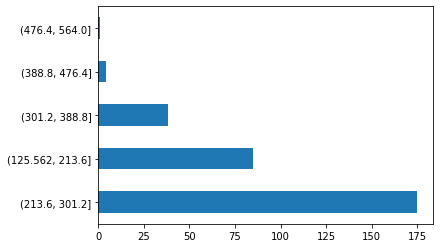

In [26]:
heartdf['cholesterol'].value_counts().plot(kind='barh')
plt.show()

In [27]:
#quantized bins

heartdf['cholesterol'] = pd.qcut(heartdf['chol'], 5, duplicates='drop')
heartdf[['chol', 'cholesterol']]

,chol,cholesterol
0,233,"(230.0, 254.0]"
1,250,"(230.0, 254.0]"
2,204,"(125.999, 204.0]"
3,236,"(230.0, 254.0]"
4,354,"(285.2, 564.0]"
...,...,...
298,241,"(230.0, 254.0]"
299,264,"(254.0, 285.2]"
300,193,"(125.999, 204.0]"
301,131,"(125.999, 204.0]"


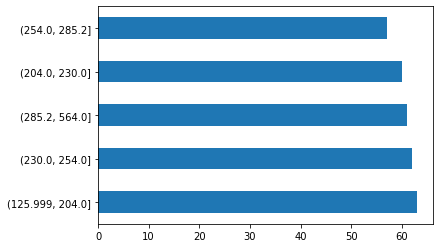

In [28]:
heartdf['cholesterol'].value_counts().plot(kind='barh')
plt.show()

In [29]:
#reset dataset
heartdf = pd.read_csv(url)

##Top & Bottom Coding

In [30]:
#top coding
greater_than_3 = heartdf[heartdf['oldpeak']>3.0].index.to_list()

In [31]:
#bottom coding
smaller_than_140 = heartdf[heartdf['thalachh']<140].index.to_list()

In [32]:
heartdf.loc[greater_than_3, 'oldpeak'] = ">3.0"
heartdf.loc[smaller_than_140, 'thalachh'] = "<140"
heartdf[(heartdf['oldpeak']==">3.0") | (heartdf['oldpeak']=="<140")]

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
1,37,1,2,130,250,0,1,187,0,>3.0,0,0,2,1
101,59,1,3,178,270,0,0,145,0,>3.0,0,0,3,1
167,62,0,0,140,268,0,0,160,0,>3.0,0,2,2,0
169,53,1,0,140,203,1,0,155,1,>3.0,0,0,3,0
173,58,1,2,132,224,0,0,173,0,>3.0,2,2,3,0
195,59,1,0,170,326,0,0,140,1,>3.0,0,0,3,0
196,46,1,2,150,231,0,1,147,0,>3.0,1,0,2,0
204,62,0,0,160,164,0,0,145,0,>3.0,0,3,3,0
211,61,1,0,120,260,0,1,140,1,>3.0,1,1,3,0
220,63,0,0,150,407,0,0,154,0,>3.0,1,3,3,0


In [33]:
#reset dataset
heartdf = pd.read_csv(url)

##Generalization

In [34]:
heartdf['cp'].unique()

array([3, 2, 1, 0])

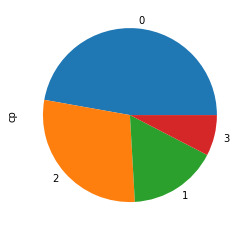

In [35]:
heartdf['cp'].value_counts().plot(kind='pie')
plt.show()

In [36]:
#prepare a generalization map
gen_map = {3: 'Non-Angina pectoris',2: 'Non-Angina pectoris', 1:'Angina pectoris',
           0:'Angina pectoris'}
heartdf['General disease'] = heartdf['cp'].replace(gen_map)
heartdf[['cp', 'General disease']]

,cp,General disease
0,3,Non-Angina pectoris
1,2,Non-Angina pectoris
2,1,Angina pectoris
3,1,Angina pectoris
4,0,Angina pectoris
...,...,...
298,0,Angina pectoris
299,3,Non-Angina pectoris
300,0,Angina pectoris
301,0,Angina pectoris


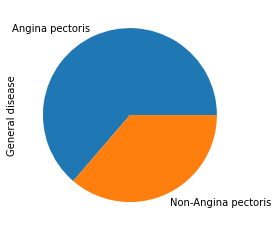

In [37]:
heartdf['General disease'].value_counts().plot(kind='pie')
plt.show()

In [38]:
#reset dataset
heartdf = pd.read_csv(url)

##Resampling

In [39]:
def resampling_values(data, k=13):
    
    sM = npr.choice(data, size=(len(data), k))
    rows, cols = sM.shape
    sMs = np.array([sorted(sM[:, c]) for c in range(cols)]).T
    means = np.mean(sMs, axis=1)
    released = np.zeros(len(data))
    for e, i in enumerate(np.argsort(data)):
        released[i] = means[e]
    return released

In [40]:
values = resampling_values(heartdf['trtbps'])
print(f"original: {heartdf['trtbps'].to_list()[:10]}")
print(f"released: {list(values[:10])}")

original: [145, 130, 130, 120, 120, 140, 140, 120, 172, 150]
released: [143.84615384615384, 131.07692307692307, 131.07692307692307, 120.0, 120.0, 139.84615384615384, 139.84615384615384, 119.6923076923077, 173.23076923076923, 148.15384615384616]


##Correlation Matrix

In [41]:
url = 'https://raw.githubusercontent.com/Kekkodf/Privacy-Preserving-Information-Access/main/heart.csv'

heartdf = pd.read_csv(url)

In [42]:
#identify the variable that you want to apply the noise on
variables = ["restecg", "thalachh", "oldpeak", "slp"]

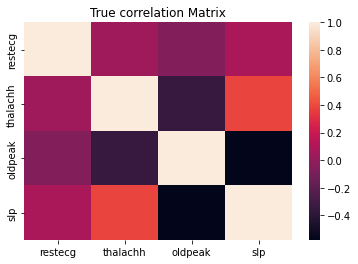

In [43]:
corr = heartdf[variables].corr()
ax = sns.heatmap(corr)
ax.set_title('True correlation Matrix')
plt.show()

##Random noise: uncorrelated additive noise

In [44]:
sigmas2 = heartdf[variables].std()**2
print(f"stds: {sigmas2}")
alpha = 2.2
scaled_sigmas2 = sigmas2*alpha

stds: restecg       0.276528
thalachh    524.646406
oldpeak       1.348095
slp           0.379735
dtype: float64


In [45]:
# generate the random noise with mean 0 and the computed standard deviations
noise = npr.normal(
                size=(len(heartdf.index), len(variables)), #set the size of the data
                loc=0, #set the mean 
                scale=scaled_sigmas2 #set the standard deviations
                  )

noised_idf = heartdf.copy()
noised_idf[variables] += noise

In [46]:
noised_idf[variables].head()

,restecg,thalachh,oldpeak,slp
0,-1.371107,812.548151,1.086715,-0.370299
1,0.370938,-310.260237,0.973492,-0.197942
2,0.264089,-1319.320819,6.431059,1.714355
3,0.677046,-232.208723,8.307441,1.433032
4,0.691722,350.562188,1.345832,2.428316


In [47]:
heartdf[variables].head()

,restecg,thalachh,oldpeak,slp
0,0,150,2.3,0
1,1,187,3.5,0
2,0,172,1.4,2
3,1,178,0.8,2
4,1,163,0.6,2


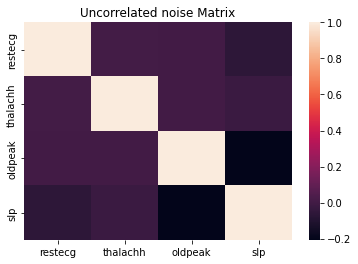

In [48]:
corr = noised_idf[variables].corr()
ax = sns.heatmap(corr)
ax.set_title('Uncorrelated noise Matrix')
plt.show()

##Random noise: correlated additive noise

In [49]:
#compute the covariance matrix
covm = heartdf[variables].cov()
print(covm.shape)
print(np.diag(covm)) # the diagonal of the covariance matrix, contains the variance

(4, 4)
[2.76528315e-01 5.24646406e+02 1.34809521e+00 3.79734662e-01]


In [50]:
#generate the noise using the covariance matrix
covnoise = npr.multivariate_normal(np.zeros(len(variables)), covm, size=len(heartdf.index))

In [51]:
#add the noise to the data
noisedc_idf = heartdf.copy()
noisedc_idf[variables] += covnoise
noisedc_idf.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,1.190935,118.212566,0,3.039052,-0.532159,0,1,1
1,37,1,2,130,250,0,0.766800,221.183840,0,4.361938,0.906939,0,2,1
2,41,0,1,130,204,0,0.466866,174.903392,0,2.315179,1.704782,0,2,1
3,56,1,1,120,236,0,1.478673,177.623919,0,-0.531225,3.072982,0,2,1
4,57,0,0,120,354,0,0.643452,158.808667,1,-0.577684,2.325776,0,2,1


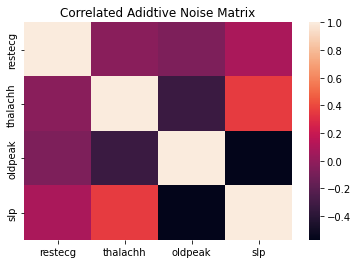

In [52]:
corr = noisedc_idf[variables].corr()
ax = sns.heatmap(corr)
ax.set_title('Correlated Adidtive Noise Matrix')
plt.show()

#MICRODATA: GENERATION

##Cholesky decomposition

In [53]:
covm = heartdf[variables].cov()
U = cholesky(covm)
print(U.T.conj()@U)

[[ 2.76528315e-01  5.31462418e-01 -3.58828929e-02  3.01510283e-02]
 [ 5.31462418e-01  5.24646406e+02 -9.15351780e+00  5.45936878e+00]
 [-3.58828929e-02 -9.15351780e+00  1.34809521e+00 -4.13218805e-01]
 [ 3.01510283e-02  5.45936878e+00 -4.13218805e-01  3.79734662e-01]]


In [54]:
R =  npr.multivariate_normal(np.zeros(len(variables)), np.eye(len(variables)), size=len(heartdf.index))
generated_heart = R@U

In [55]:
print(np.cov(generated_heart.T))

[[ 2.48824514e-01  1.88415727e+00 -2.91795412e-02  3.19989878e-02]
 [ 1.88415727e+00  5.45392611e+02 -1.07185308e+01  5.80240317e+00]
 [-2.91795412e-02 -1.07185308e+01  1.35627180e+00 -3.75716196e-01]
 [ 3.19989878e-02  5.80240317e+00 -3.75716196e-01  3.34254771e-01]]


##Blank and Impute

In [56]:
proportion = 0.5
removable = [(r, c) for r in range(len(heartdf.index)) for c in range(len(variables)) if npr.random() < proportion]
means = heartdf[variables].mean()

heart_bi = heartdf[variables].copy()
for r, c in removable:
    heart_bi.iloc[r, c] = means[c]

In [57]:
heart_bi.head()

,restecg,thalachh,oldpeak,slp
0,0.000000,149.646865,2.300000,0.0
1,0.528053,187.000000,3.500000,0.0
2,0.528053,172.000000,1.400000,2.0
3,1.000000,149.646865,1.039604,2.0
4,1.000000,149.646865,1.039604,2.0


In [58]:
heartdf.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


#Disclosure Risk

##Uniqueness

Measuring the uniqueness of the data.

In [59]:
url = 'https://raw.githubusercontent.com/Kekkodf/Privacy-Preserving-Information-Access/main/heart.csv'

heartdf = pd.read_csv(url)
heartdf

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [60]:
variables = ['age', 'sex', 'cp', 'trtbps', 'chol', 'fbs', 'restecg', 'thalachh', 'exng', 'oldpeak', 'slp', 'caa', 'thall', 'output']
PU = (heartdf[variables].value_counts() == 1).sum()/len(heartdf.index)
print(f"population uniqueness: {PU:.3f}")

population uniqueness: 0.993


##Record linkage


In [61]:
#creating another dataframe with rounded values for certain attributes
df_modified = heartdf.copy()

mapper = {'age' : 'years', 'sex' : 'gender', 'cp':'Chest Pain', 'trtbps': 'Resting blood preassure', 
          'chol': 'Cholesterol', 'fbs': 'Fasting blood sugar', 'restecg' : 'Resting Electrocardiogram', 
          'thalachh': 'Maximum heart beat', 'exng' : 'Exercise', 'oldpeak':'ST depression', 
          'slp': 'Slope of ST', 'caa' : 'Major Vessels', 'thall' : 'Talassemia rate', 'output':'Diagnosis'}
df_modified.rename(columns = mapper, inplace = True)

In [62]:
df_modified['Cholesterol'] = base_round(df_modified['Cholesterol'], 6)
df_modified['Maximum heart beat'] = base_round(df_modified['Maximum heart beat'], 8)
df_modified['Resting blood preassure'] = base_round(df_modified['Resting blood preassure'], 11)
df_modified = df_modified.sample(frac = 1).reset_index(drop=True)

In [63]:
#adding a column for ID
ids = np.random.rand(303, 1)*1000000
df_modified.insert(0, "ID Patient", ids.astype(int))
df_modified.head()

,ID Patient,years,gender,Chest Pain,Resting blood preassure,Cholesterol,Fasting blood sugar,Resting Electrocardiogram,Maximum heart beat,Exercise,ST depression,Slope of ST,Major Vessels,Talassemia rate,Diagnosis
0,289534,55,1,0,143,216,0,1,112,1,5.6,0,0,3,0
1,367300,64,1,3,165,228,0,0,152,0,0.6,1,0,3,1
2,204863,52,1,1,132,204,1,1,184,0,0.0,2,0,2,1
3,155714,40,1,0,154,222,0,1,184,0,0.0,2,0,3,0
4,824495,52,1,0,132,252,0,1,160,1,0.0,2,1,3,0


In [64]:
#Generating some ID for the patients in the original datasets.
ids = np.random.rand(303, 1)*1000000
heartdf.insert(0, "id", ids.astype(int))
heartdf.head()

,id,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,426672,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,58223,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,86156,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,237340,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,502067,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [65]:
#setting the IDs as index
heartdf.set_index('id', inplace = True)

In [66]:
#setting the IDs as index
df_modified.set_index('ID Patient', inplace = True)

In [67]:
# Build the indexer
indexer = recordlinkage.Index()
# Can use full or block
indexer.full()
#indexer.block(left_on='fbs', right_on='Fasting blood sugar') \\ Use blocks to limit the pool of potential matches

candidates = indexer.index(heartdf, df_modified)
print(len(candidates))

91809


In [68]:
compare = recordlinkage.Compare()#Initialize comparison

compare.exact('cp', 'Chest Pain', label = 'Kind of arithmia') #compare Chest Pain
compare.exact('age', 'years', label = 'Generation') #compare age
compare.exact('thalachh', 'Maximum heart beat', label = 'Max beat') #compare MHB
compare.exact('oldpeak', 'ST depression', label = 'Kind of ST segment') #compare ST segment
compare.exact('thall', 'Talassemia rate', label = 'Talassemia') #compare Talassemia

features = compare.compute(candidates, heartdf, df_modified) # perform all the feature comparisons 

In [69]:
features

Kind of arithmia  Generation  Max beat  Kind of ST segment  \
id     ID Patient                                                               
426672 289534                     0           0         0                   0   
       367300                     1           0         0                   0   
       204863                     0           0         0                   0   
       155714                     0           0         0                   0   
       824495                     0           0         0                   0   
...                             ...         ...       ...                 ...   
342137 383234                     0           0         0                   0   
       972472                     0           0         0                   0   
       729213                     0           0         0                   0   
       622235                     0           0         0                   0   
       8525                       0           0         0                   1   

                   Talassemia  
id     ID Patient              
426672 289534               0  
       367300               0  
       204863               0  
       155714               0  
       824495               0  
...                       ...  
342137 383234               1  
       972472               0  
       729213               1  
       622235               1  
       8525                 1  

[91809 rows x 5 columns]

In [70]:
features.sum(axis=1).value_counts().sort_index(ascending=False) 
#Given the large number of records with no matches, 
#it is a little hard to see how many matches we might have. 
#We can sum up the individual scores to see about the quality of the matches.

5       42
4      381
3     3098
2    19265
1    39194
0    29829
dtype: int64

In [71]:
#let’s get all the records with >1 matches and add a total score:
potential_matches = features[features.sum(axis=1) > 1].reset_index()
potential_matches['Score'] = potential_matches.loc[:, 'Kind of arithmia':'Talassemia'].sum(axis=1)

In [72]:
potential_matches

,id,ID Patient,Kind of arithmia,Generation,Max beat,Kind of ST segment,Talassemia,Score
0,426672,477505,0,0,0,1,1,2
1,426672,609573,1,0,0,0,1,2
2,426672,77493,1,1,0,1,1,4
3,58223,520517,1,0,0,0,1,2
4,58223,32620,1,0,0,0,1,2
...,...,...,...,...,...,...,...,...
22781,342137,922331,0,0,0,1,1,2
22782,342137,797980,1,0,0,1,0,2
22783,342137,826848,1,0,0,1,1,3
22784,342137,583662,0,0,0,1,1,2


Example of closeness between two patients.

In [74]:
heartdf.loc[426672,:]

age          63.0
sex           1.0
cp            3.0
trtbps      145.0
chol        233.0
fbs           1.0
restecg       0.0
thalachh    150.0
exng          0.0
oldpeak       2.3
slp           0.0
caa           0.0
thall         1.0
output        1.0
Name: 426672, dtype: float64

In [75]:
df_modified.loc[77493,:]

years                         63.0
gender                         1.0
Chest Pain                     3.0
Resting blood preassure      143.0
Cholesterol                  234.0
Fasting blood sugar            1.0
Resting Electrocardiogram      0.0
Maximum heart beat           152.0
Exercise                       0.0
ST depression                  2.3
Slope of ST                    0.0
Major Vessels                  0.0
Talassemia rate                1.0
Diagnosis                      1.0
Name: 77493, dtype: float64